# Inference tryout

## Imports

In [1]:
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from catalyst import utils as cutils, dl, metrics
from timm.models import resnet

%matplotlib inline


## Getting dataset

In [2]:
dataset_file_path = '../../data/dataset/test.csv'
test_df = pd.read_csv(dataset_file_path, index_col=False)
test_df

,path,big,small
0,../../data/dataset/test/big/IMG_7880.jpeg,1,0
1,../../data/dataset/test/big/IMG_7856.jpeg,1,0
2,../../data/dataset/test/big/IMG_7850.jpeg,1,0
3,../../data/dataset/test/big/IMG_7877.jpeg,1,0
4,../../data/dataset/test/big/IMG_7865.jpeg,1,0
5,../../data/dataset/test/big/IMG_7868.jpeg,1,0
6,../../data/dataset/test/small/IMG_7899.jpeg,0,1
7,../../data/dataset/test/small/IMG_7893.jpeg,0,1
8,../../data/dataset/test/small/IMG_7887.jpeg,0,1
9,../../data/dataset/test/small/IMG_7902.jpeg,0,1


## Loading model

In [3]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model, classes, size, thresholds):
        super().__init__()
        self.model = model
        self.classes = classes
        self.size = size
        self.thresholds = thresholds
    
    def forward(self, image):
        return torch.sigmoid(self.model.forward(image))

In [40]:
for root, dirs, files in os.walk('../../data/checkpoints/Classification-parts'):
    for file in files:
        if file == "last.pth":
             checkpoint_path = os.path.join(root, file)
                
model = resnet.resnet18(pretrained=True, num_classes=2)

checkpoint = cutils.load_checkpoint(path=checkpoint_path)
cutils.unpack_checkpoint(checkpoint = checkpoint, model = model)

In [41]:
wrapper = ModelWrapper(model, ['big', 'small'], (224, 224), [0.5, 0.5])


In [42]:
scripted_model = torch.jit.script(wrapper)
torch.jit.save(scripted_model, '../../data/checkpoints/Classification-parts/classification_parts_v2.pt')

In [43]:
model2 = torch.jit.load('../../data/checkpoints/Classification-parts/classification_parts_v2.pt')

## Getting random image

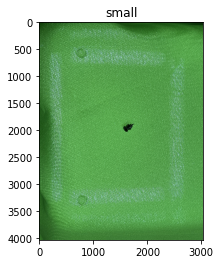

In [48]:
random_image_path, is_big = test_df.sample(n=1).iloc[0][['path', 'big']]
size = 'big' if is_big == 1 else 'small'
image = cv2.imread(random_image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.title(size)
plt.imshow(image)

## Preprocess image

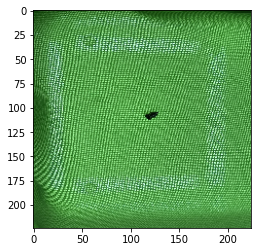

In [49]:
image = image.astype(np.float32)
image /= 255.0
image = cv2.resize(image, (224, 224))
plt.imshow(image)

In [50]:
image = np.transpose(image, (2, 0, 1))
image -= np.array([0.485, 0.456, 0.406])[:, None, None]
image /= np.array([0.229, 0.224, 0.225])[:, None, None]
image_tensor = torch.from_numpy(image)[None]


## Inference

In [51]:
model_predict = model2(image_tensor).detach()[0].numpy()
predicted_class = model2.classes[np.where(model_predict == np.max(model_predict))[0][0]]
predicted_class

'big'